# Day 09. Exercise 00
# Regularization

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import joblib 

## 1. Preprocessing

1. Read the file `dayofweek.csv` that you used in the previous day to a dataframe.
2. Using `train_test_split` with parameters `test_size=0.2`, `random_state=21` get `X_train`, `y_train`, `X_test`, `y_test`. Use the additional parameter `stratify`.

In [2]:
df = pd.read_csv('../data/dayofweek.csv')
df.shape

(1686, 44)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('dayofweek', axis=1), df['dayofweek'], test_size=0.2, random_state=21, stratify=df['dayofweek'])

In [4]:
X_train.shape, X_test.shape

((1348, 43), (338, 43))

In [5]:
y_train.shape, y_test.shape

((1348,), (338,))

In [6]:
X = df.drop('dayofweek', axis=1)
y = df['dayofweek']

## 2. Logreg regularization

### a. Default regularization

1. Train a baseline model with the only parameters `random_state=21`, `fit_intercept=False`.
2. Use stratified K-fold cross-validation with `10` splits to evaluate the accuracy of the model


The result of the code where you trained and evaluated the baseline model should be exactly like this (use `%%time` to get the info about how long it took to run the cell):

```
train -  0.62902   |   valid -  0.59259
train -  0.64633   |   valid -  0.62963
train -  0.63479   |   valid -  0.56296
train -  0.65622   |   valid -  0.61481
train -  0.63397   |   valid -  0.57778
train -  0.64056   |   valid -  0.59259
train -  0.64138   |   valid -  0.65926
train -  0.65952   |   valid -  0.56296
train -  0.64333   |   valid -  0.59701
train -  0.63674   |   valid -  0.62687
Average accuracy on crossval is 0.60165
Std is 0.02943
```

In [7]:
%%time
logreg = LogisticRegression(random_state=21, fit_intercept=False)
kf = StratifiedKFold(n_splits=10, random_state=21, shuffle=True)
valid_scores = []
for train_index, test_index in kf.split(X, y):
    X_train_new, X_test_new = X.iloc[train_index], X.iloc[test_index]
    y_train_new, y_test_new = y.iloc[train_index], y.iloc[test_index]

    logreg.fit(X_train_new, y_train_new)

    y_train_pred = logreg.predict(X_train_new)
    y_test_pred = logreg.predict(X_test_new)

    #valid_score = logreg.score(X_test, y_test)
    train_score = accuracy_score(y_train_new, y_train_pred)
    valid_score = accuracy_score(y_test_new, y_test_pred)

    valid_scores.append(valid_score)
    print(f"train - {train_score:.5f} | valid - {valid_score:.5f}")
    
avg_score = np.mean(valid_scores)
std_test = np.std(valid_scores)
print(f'Average accuracy on crossval is {avg_score:.5f}')
print(f'Std is {std_test:.5f}\n')

train - 0.63546 | valid - 0.65089
train - 0.65326 | valid - 0.60947
train - 0.63942 | valid - 0.63905
train - 0.63283 | valid - 0.57988
train - 0.65590 | valid - 0.57988
train - 0.64469 | valid - 0.61538
train - 0.63702 | valid - 0.60714
train - 0.63636 | valid - 0.59524
train - 0.64295 | valid - 0.68452
train - 0.63834 | valid - 0.56548
Average accuracy on crossval is 0.61269
Std is 0.03471

CPU times: user 4.17 s, sys: 15 s, total: 19.2 s
Wall time: 3.22 s


### b. Optimizing regularization parameters

1. In the cells below try different values of penalty: `none`, `l1`, `l2` – you can change the values of solver too.

In [8]:
def opt_reg_params(model, X, y, **kwargs) -> tuple:
    if kwargs:
        model.set_params(**kwargs)
    kf = StratifiedKFold(n_splits=10, random_state=21, shuffle=True)
    valid_scores = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        train_score = model.score(X_train, y_train)
        valid_score = model.score(X_test, y_test)

        valid_scores.append(valid_score)
        print(f"train - {train_score:.5f} | valid - {valid_score:.5f}")
    
    avg_score = np.mean(valid_scores)
    std_test = np.std(valid_scores)
    print(f'Average accuracy on crossval is {avg_score:.5f}')
    print(f'Std is {std_test:.5f}\n')
    return round(avg_score, 5), round(std_test, 5)

## Compatibility:
- 'none'/None 	'lbfgs', 'newton-cg', 'sag', 'saga'	No regularization
- 'l1'	        'liblinear', 'saga'	'liblinear' is better for small datasets
- 'l2'	         All except 'newton-cholesky'	Default solver: 'lbfgs'
- 'elasticnet'	'saga' only	Requires l1_ratio parameter

In [9]:
try:
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    for solver in ['newton-cg', 'sag', 'saga','lbfgs']:
        print(f'Result for {solver.upper()} solver.')
        opt_reg_params(LogisticRegression(), X, y, random_state=21, fit_intercept=False, penalty='none', solver=solver)
except Exception as e:
    print(f'Solver {solver} failed: {str(e)}') 
finally:
    warnings.filterwarnings("default", category=ConvergenceWarning) 

Result for NEWTON-CG solver.
train - 0.66777 | valid - 0.68639
train - 0.66051 | valid - 0.65089
train - 0.66183 | valid - 0.68639
train - 0.67106 | valid - 0.59763
train - 0.67436 | valid - 0.59172
train - 0.66117 | valid - 0.63314
train - 0.67062 | valid - 0.61905
train - 0.65547 | valid - 0.61310
train - 0.65744 | valid - 0.67857
train - 0.66469 | valid - 0.58929
Average accuracy on crossval is 0.63462
Std is 0.03678

Result for SAG solver.
train - 0.66645 | valid - 0.68639
train - 0.66051 | valid - 0.65089
train - 0.66117 | valid - 0.68639
train - 0.67040 | valid - 0.59763
train - 0.67304 | valid - 0.57988
train - 0.66051 | valid - 0.63314
train - 0.67062 | valid - 0.61905
train - 0.65481 | valid - 0.61310
train - 0.65744 | valid - 0.67857
train - 0.66469 | valid - 0.58333
Average accuracy on crossval is 0.63284
Std is 0.03902

Result for SAGA solver.
train - 0.66513 | valid - 0.68639
train - 0.66249 | valid - 0.64497
train - 0.66051 | valid - 0.68639
train - 0.67040 | valid - 0.59

In [10]:
try:
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    for solver in ['saga']:
        print(f'Result for {solver.upper()} solver.')
        opt_reg_params(LogisticRegression(), X, y, random_state=21, fit_intercept=False, penalty='l1', solver=solver)
except Exception as e:
    print(f'Solver {solver} failed: {str(e)}') 
finally:
    warnings.filterwarnings("default", category=ConvergenceWarning) 

Result for SAGA solver.
train - 0.64206 | valid - 0.63905
train - 0.64535 | valid - 0.63314
train - 0.63876 | valid - 0.65089
train - 0.63678 | valid - 0.57988
train - 0.65458 | valid - 0.56805
train - 0.64140 | valid - 0.61538
train - 0.64888 | valid - 0.60714
train - 0.62978 | valid - 0.57738
train - 0.62846 | valid - 0.67262
train - 0.64559 | valid - 0.55952
Average accuracy on crossval is 0.61031
Std is 0.03645



In [11]:
for solver in ['newton-cg', 'sag', 'saga','lbfgs']:
   print(f'Result for {solver.upper()} solver.')
   opt_reg_params(LogisticRegression(), X, y, random_state=21, fit_intercept=False, penalty='l2', solver=solver)

Result for NEWTON-CG solver.
train - 0.63546 | valid - 0.65089
train - 0.65326 | valid - 0.60947
train - 0.63942 | valid - 0.63905
train - 0.63283 | valid - 0.57988
train - 0.65590 | valid - 0.57988
train - 0.64469 | valid - 0.61538
train - 0.63702 | valid - 0.60714
train - 0.63636 | valid - 0.59524
train - 0.64295 | valid - 0.68452
train - 0.63900 | valid - 0.56548
Average accuracy on crossval is 0.61269
Std is 0.03471

Result for SAG solver.
train - 0.63546 | valid - 0.65089
train - 0.65326 | valid - 0.60947
train - 0.63942 | valid - 0.63905
train - 0.63283 | valid - 0.57988
train - 0.65590 | valid - 0.57988
train - 0.64469 | valid - 0.61538
train - 0.63702 | valid - 0.60714
train - 0.63636 | valid - 0.59524
train - 0.64295 | valid - 0.68452
train - 0.63900 | valid - 0.56548
Average accuracy on crossval is 0.61269
Std is 0.03471

Result for SAGA solver.
train - 0.63546 | valid - 0.65089
train - 0.65326 | valid - 0.60947
train - 0.63942 | valid - 0.63905
train - 0.63283 | valid - 0.57

## 3. SVM regularization

### a. Default regularization

1. Train a baseline model with the only parameters `probability=True`, `kernel='linear'`, `random_state=21`.
2. Use stratified K-fold cross-validation with `10` splits to evaluate the accuracy of the model.
3. The format of the result of the code where you trained and evaluated the baseline model should be similar to what you have got for the logreg.

In [12]:
%%time
opt_reg_params(SVC(), X, y, random_state=21, kernel='linear', probability=True)

train - 0.70138 | valid - 0.71598
train - 0.69677 | valid - 0.68639
train - 0.70402 | valid - 0.71006
train - 0.69941 | valid - 0.63905
train - 0.71127 | valid - 0.62130
train - 0.70336 | valid - 0.69822
train - 0.69038 | valid - 0.67857
train - 0.70487 | valid - 0.69048
train - 0.69895 | valid - 0.71429
train - 0.70026 | valid - 0.61905
Average accuracy on crossval is 0.67734
Std is 0.03553

CPU times: user 12.2 s, sys: 450 ms, total: 12.6 s
Wall time: 12.3 s


(0.67734, 0.03553)

### b. Optimizing regularization parameters

1. In the cells below try different values of the parameter `C`.

- C - параметр функции потерь, определяющий силу L2 регуляризации (чем он меньше, тем шире граница и тем больше ошибок допускает модель, выше генерализация. и наоборот) 
- ОБРАТНО пропорционален лямбде в лоссе для СВМ

In [13]:
best_acc = 0
best_c = 0
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
   print(f'Result for C = {C}')
   avg_score, std_test = opt_reg_params(SVC(), X, y, random_state=21, kernel='linear', probability=True, C=C)
   if avg_score > best_acc:
       best_acc = avg_score
       best_c = C
print (f'Best accuracy on crossval is {best_acc:.5f} with C={best_c}')

Result for C = 0.001
train - 0.23467 | valid - 0.23669
train - 0.23467 | valid - 0.23669
train - 0.23467 | valid - 0.23669
train - 0.23467 | valid - 0.23669
train - 0.23467 | valid - 0.23669
train - 0.23467 | valid - 0.23669
train - 0.23518 | valid - 0.23214
train - 0.23518 | valid - 0.23214
train - 0.23518 | valid - 0.23214
train - 0.23518 | valid - 0.23214
Average accuracy on crossval is 0.23487
Std is 0.00223

Result for C = 0.01
train - 0.40804 | valid - 0.41420
train - 0.41859 | valid - 0.38462
train - 0.43771 | valid - 0.41420
train - 0.44034 | valid - 0.44970
train - 0.39684 | valid - 0.36095
train - 0.43705 | valid - 0.48521
train - 0.44137 | valid - 0.43452
train - 0.39789 | valid - 0.40476
train - 0.44137 | valid - 0.42857
train - 0.43412 | valid - 0.45238
Average accuracy on crossval is 0.42291
Std is 0.03380

Result for C = 0.1
train - 0.58075 | valid - 0.59763
train - 0.57877 | valid - 0.54438
train - 0.57284 | valid - 0.57396
train - 0.58603 | valid - 0.61538
train - 0.59

## 4. Tree

### a. Default regularization

1. Train a baseline model with the only parameter `max_depth=10` and `random_state=21`.
2. Use stratified K-fold cross-validation with `10` splits to evaluate the accuracy of the model.
3. The format of the result of the code where you trained and evaluated the baseline model should be similar to what you have got for the logreg.

In [14]:
%%time
opt_reg_params(DecisionTreeClassifier(), X, y, random_state=21, max_depth=10)

train - 0.82004 | valid - 0.79290
train - 0.82663 | valid - 0.69231
train - 0.82927 | valid - 0.76923
train - 0.81806 | valid - 0.71598
train - 0.82268 | valid - 0.74556
train - 0.80554 | valid - 0.77515
train - 0.83465 | valid - 0.75595
train - 0.81555 | valid - 0.76786
train - 0.81225 | valid - 0.76190
train - 0.81752 | valid - 0.67262
Average accuracy on crossval is 0.74495
Std is 0.03685

CPU times: user 203 ms, sys: 0 ns, total: 203 ms
Wall time: 200 ms


(0.74495, 0.03685)

### b. Optimizing regularization parameters

1. In the cells below try different values of the parameter `max_depth`.
2. As a bonus, play with other regularization parameters trying to find the best combination.

In [15]:
best_acc = 0
best_max_depth = 0
for max_depth in range (1, 20):
   print(f'Result for max_depth= {max_depth}')
   avg_score, std_test = opt_reg_params(DecisionTreeClassifier(), X, y, random_state=21, max_depth=max_depth)
   if avg_score > best_acc:
       best_acc = avg_score
       best_max_depth = max_depth
print (f'Best accuracy on crossval is {best_acc:.5f} with max_depth={best_max_depth}')
# чем больше max_depth, тем больше accuracy

Result for max_depth= 1
train - 0.35662 | valid - 0.36686
train - 0.35992 | valid - 0.33728
train - 0.35860 | valid - 0.34911
train - 0.35662 | valid - 0.36686
train - 0.36058 | valid - 0.33136
train - 0.35333 | valid - 0.39645
train - 0.35837 | valid - 0.35119
train - 0.35837 | valid - 0.35119
train - 0.35705 | valid - 0.36310
train - 0.35705 | valid - 0.36310
Average accuracy on crossval is 0.35765
Std is 0.01731

Result for max_depth= 2
train - 0.43968 | valid - 0.43195
train - 0.44034 | valid - 0.42604
train - 0.44298 | valid - 0.40237
train - 0.43902 | valid - 0.43787
train - 0.44166 | valid - 0.41420
train - 0.43507 | valid - 0.47337
train - 0.44137 | valid - 0.41667
train - 0.43347 | valid - 0.48810
train - 0.43939 | valid - 0.43452
train - 0.43610 | valid - 0.46429
Average accuracy on crossval is 0.43894
Std is 0.02632

Result for max_depth= 3
train - 0.49901 | valid - 0.48521
train - 0.49506 | valid - 0.42604
train - 0.49835 | valid - 0.49112
train - 0.49110 | valid - 0.47929


In [16]:
from sklearn.model_selection import RandomizedSearchCV

def rand_search(model, param_dist, X_train, y_train, X_test, y_test, **kwargs) -> None:
    if kwargs:
        model.set_params(**kwargs)
        
    search = RandomizedSearchCV(model, param_dist, n_iter=50, cv=5, scoring='accuracy', random_state=21, n_jobs=-1)
    search.fit(X_train, y_train)

    print("Best parameters:")
    for param, value in search.best_params_.items():
        print(f"{param}: {value}")

    print(f"\nBest cross-validation accuracy: {search.best_score_:.4f}")

    best_model = search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    print(f"Test set accuracy: {test_score:.4f}")

In [17]:
param_dist = {
    'max_depth': [None, 3, 5, 7, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0, 0.01, 0.1]
}
rand_search(DecisionTreeClassifier(), param_dist, X_train, y_train, X_test, y_test, random_state=21)

Best parameters:
min_samples_split: 5
min_samples_leaf: 2
max_features: None
max_depth: 25
criterion: entropy
ccp_alpha: 0

Best cross-validation accuracy: 0.8271
Test set accuracy: 0.8491


In [18]:
from sklearn.model_selection import GridSearchCV

def grid_search(model, param_grid, X_train, y_train, X_test, y_test, **kwargs) -> None:
    if kwargs:
        model.set_params(**kwargs)

    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"{param}: {value}")

    print(f"\nBest cross-validation accuracy: {grid_search.best_score_:.4f}")

    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    print(f"Test set accuracy: {test_score:.4f}")

In [19]:
param_grid = {
    'max_depth': [None, 3, 5, 7, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0, 0.01, 0.1]
}
grid_search(DecisionTreeClassifier(), param_grid, X_train, y_train, X_test, y_test, random_state=21)

Best parameters:
ccp_alpha: 0
criterion: gini
max_depth: None
max_features: None
min_samples_leaf: 1
min_samples_split: 2

Best cross-validation accuracy: 0.8694
Test set accuracy: 0.8728


## 5. Random forest

### a. Default regularization

1. Train a baseline model with the only parameters `n_estimators=50`, `max_depth=14`, `random_state=21`.
2. Use stratified K-fold cross-validation with `10` splits to evaluate the accuracy of the model.
3. The format of the result of the code where you trained and evaluated the baseline model should be similar to what you have got for the logreg.

In [20]:
opt_reg_params(RandomForestClassifier(), X, y, random_state=21, max_depth=14, n_estimators=50)

train - 0.95979 | valid - 0.89349
train - 0.97231 | valid - 0.88757
train - 0.96638 | valid - 0.90533
train - 0.96902 | valid - 0.90533
train - 0.96374 | valid - 0.87574
train - 0.96638 | valid - 0.91124
train - 0.96377 | valid - 0.92262
train - 0.97299 | valid - 0.91071
train - 0.96245 | valid - 0.88690
train - 0.97101 | valid - 0.89286
Average accuracy on crossval is 0.89918
Std is 0.01346



(0.89918, 0.01346)

### b. Optimizing regularization parameters

1. In the new cells try different values of the parameters `max_depth` and `n_estimators`.
2. As a bonus, play with other regularization parameters trying to find the best combination.

In [21]:
best_acc = 0
best_max_depth = 0
for max_depth in range (1, 20):
   print(f'Result for max_depth= {max_depth}')
   avg_score, std_test = opt_reg_params(RandomForestClassifier(), X, y, random_state=21, max_depth=max_depth, n_estimators=50)
   if avg_score > best_acc:
       best_acc = avg_score
       best_max_depth = max_depth
print (f'Best accuracy on crossval is {best_acc:.5f} with max_depth={best_max_depth}')
# чем больше max_depth, тем больше accuracy + переобучение

Result for max_depth= 1
train - 0.42386 | valid - 0.42012
train - 0.38497 | valid - 0.36095
train - 0.42189 | valid - 0.42012
train - 0.38695 | valid - 0.39645
train - 0.39354 | valid - 0.35503
train - 0.41595 | valid - 0.47337
train - 0.38669 | valid - 0.39881
train - 0.38669 | valid - 0.39286
train - 0.39460 | valid - 0.38095
train - 0.38801 | valid - 0.38690
Average accuracy on crossval is 0.39856
Std is 0.03212

Result for max_depth= 2
train - 0.45880 | valid - 0.45562
train - 0.46078 | valid - 0.43195
train - 0.45353 | valid - 0.44970
train - 0.45880 | valid - 0.45562
train - 0.46210 | valid - 0.42012
train - 0.45353 | valid - 0.50296
train - 0.47628 | valid - 0.45833
train - 0.44203 | valid - 0.42857
train - 0.44928 | valid - 0.42857
train - 0.45718 | valid - 0.47619
Average accuracy on crossval is 0.45076
Std is 0.02399

Result for max_depth= 3
train - 0.47594 | valid - 0.45562
train - 0.46671 | valid - 0.43787
train - 0.46935 | valid - 0.44379
train - 0.47132 | valid - 0.46154


In [22]:
best_acc = 0
best_est = 0
for n_estimators in range (200, 310, 10):
   print(f'Result for n_estimators= {n_estimators}')
   avg_score, std_test = opt_reg_params(RandomForestClassifier(), X, y, random_state=21, max_depth=14, n_estimators=n_estimators)
   if avg_score > best_acc:
       best_acc = avg_score
       best_est = n_estimators
print (f'Best accuracy on crossval is {best_acc:.5f} with n_estimators={best_est}')
# чем больше n_est, тем больше accuracy, но есть пик

Result for n_estimators= 200
train - 0.97165 | valid - 0.89941
train - 0.96836 | valid - 0.89349
train - 0.97363 | valid - 0.91716
train - 0.96770 | valid - 0.90533
train - 0.96770 | valid - 0.88166
train - 0.97495 | valid - 0.92308
train - 0.97299 | valid - 0.92857
train - 0.97628 | valid - 0.91071
train - 0.96970 | valid - 0.90476
train - 0.96970 | valid - 0.88095
Average accuracy on crossval is 0.90451
Std is 0.01532

Result for n_estimators= 210
train - 0.97363 | valid - 0.90533
train - 0.96836 | valid - 0.89941
train - 0.97363 | valid - 0.91124
train - 0.96638 | valid - 0.90533
train - 0.96836 | valid - 0.88757
train - 0.97495 | valid - 0.92308
train - 0.97167 | valid - 0.92262
train - 0.97826 | valid - 0.91071
train - 0.96904 | valid - 0.91071
train - 0.97101 | valid - 0.88690
Average accuracy on crossval is 0.90629
Std is 0.01178

Result for n_estimators= 220
train - 0.97231 | valid - 0.91124
train - 0.96836 | valid - 0.89941
train - 0.97165 | valid - 0.91124
train - 0.96704 | v

In [23]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],  
    'max_depth': [None, 5, 10, 20, 30], 
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['sqrt', 'log2', None],  
    'bootstrap': [True, False], 
    'class_weight': [None, 'balanced'] 
}

In [24]:
#grid_search(RandomForestClassifier(), param_grid, X_train, y_train, X_test, y_test, random_state=21)

## 6. Predictions

1. Choose the best model and use it to make predictions for the test dataset.
2. Calculate the final accuracy.
3. Analyze: for which weekday your model makes the most errors (in % of the total number of samples of that class in your test dataset).
4. Save the model.

In [25]:
best_model = RandomForestClassifier(random_state=21, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='entropy', max_features='sqrt', n_estimators=200, ccp_alpha=0)

In [26]:
best_model.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0, criterion='entropy', max_features='sqrt',
                       n_estimators=200, random_state=21)

In [27]:
y_pred = best_model.predict(X_test)
final_acc = accuracy_score(y_test, y_pred)
final_acc

0.9349112426035503

In [28]:
classes = best_model.classes_

In [29]:
n_classes = len(classes)
count_matrix = np.zeros((n_classes, n_classes), dtype=int)

In [30]:
for actual, pred in zip(y_test, y_pred):
    actual_idx = np.where(classes == actual)[0][0]
    pred_idx = np.where(classes == pred)[0][0]
    count_matrix[actual_idx][pred_idx] += 1

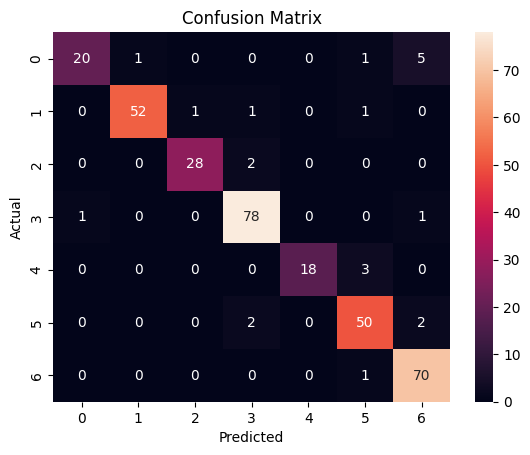

In [31]:
sns.heatmap(count_matrix, annot=True, fmt='d', 
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [32]:
total_per_class = count_matrix.sum(axis=1)
correct_predictions = np.diag(count_matrix)

In [33]:
errors_per_class = total_per_class - correct_predictions
error_rates = (errors_per_class / total_per_class) * 100
for i, weekday in enumerate(best_model.classes_):
    print(f"{weekday}: Error Rate = {error_rates[i]:.2f}%")

0: Error Rate = 25.93%
1: Error Rate = 5.45%
2: Error Rate = 6.67%
3: Error Rate = 2.50%
4: Error Rate = 14.29%
5: Error Rate = 7.41%
6: Error Rate = 1.41%


In [34]:
worst_weekday_idx = np.argmax(error_rates)
worst_weekday = best_model.classes_[worst_weekday_idx]
worst_error_rate = error_rates[worst_weekday_idx]

print(f"\nThe model makes the most errors on: {worst_weekday} ({worst_error_rate:.2f}% errors)")


The model makes the most errors on: 0 (25.93% errors)


In [35]:
file_name = 'final_model_ex00.joblib' 
joblib.dump(best_model, file_name) 

['final_model_ex00.joblib']